# Imports

In [2]:
# Configs
%load_ext autoreload
%autoreload 3
## other standard packages
import sys
## Env variables and preparation stuffs
sys.path.insert(0, "../")
from src_code.data_utils.dataset import GridDataset
from src_code.data_utils.dataset_utils import CellType, draw_image_grid
from src_code.data_utils.prompt_utils import prompt_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset
class CellType(Enum):

    FREE_CELL = 1  # Represents free space
    WALL = 2       # Represens a wall
    START = 3      # Represents the start position
    GOAL = 4       # Represents the goal position

In [7]:
# cell size in the size of the grid measured in pixels
dataset = GridDataset(grid_size=5, seed = 42, wall_symbol="#", free_symbol=".", cell_size=10)
img_rgb1, grid_world1 = dataset[0]
img_rgb2, grid_world2 = dataset[1]

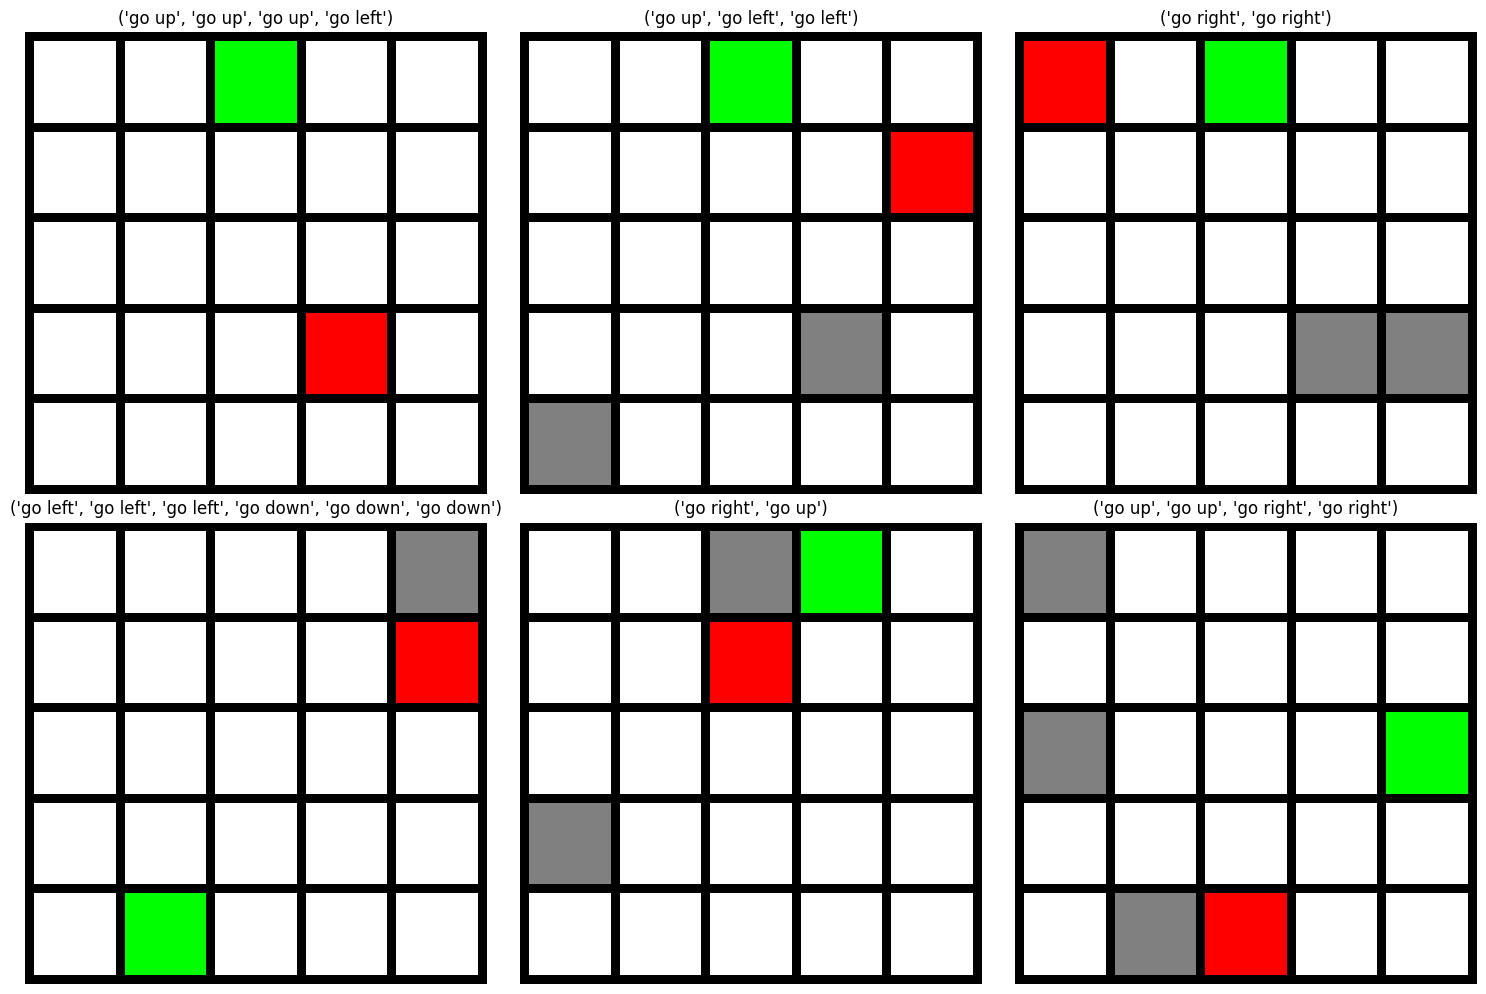

In [8]:
num_images = 6
img_title_pairs = [(dataset[i][0], f"{dataset[i][1].a_star()}") for i in range(num_images)]
draw_image_grid(img_title_pairs)

In [35]:
print(str(grid_world2))

# . . . . 
. . . . . 
# . . . G 
. . . . . 
. # S . . 



# Prompt

In [36]:
print(prompt_generator(grid_world2, img=img_rgb2, img_symbol="<image>"))

Can you find the path from the starting cell to the goal cell?
Here is an image of the grid world:
<image>
The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left' or 'go right'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 2).
The goal cell is at (2,

In [37]:
print(prompt_generator(grid_world2))

Can you find the path from the starting cell to the goal cell?
Here is the grid world:
# . . . . 
. . . . . 
# . . . G 
. . . . . 
. # S . . 

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the . cells are free cells.

Rules:
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left' or 'go right'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 2).


# Images for the paper

In [38]:
dataset = GridDataset(grid_size=5, seed = 42, wall_symbol="#", free_symbol=".", cell_size=50)
img_rgb5, grid_world5 = dataset[5]

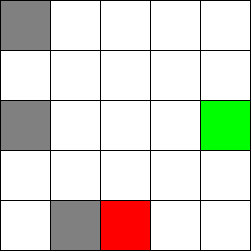

In [39]:
img_rgb5

In [40]:
print(str(grid_world5))

# . . . . 
. . . . . 
# . . . G 
. . . . . 
. # S . . 



In [41]:
grid_world5.a_star()

('go up', 'go up', 'go right', 'go right')

In [42]:
print(prompt_generator(grid_world5, pure_language=True, img=img_rgb5))

Can you find the path from the starting cell to the goal cell?
The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left' or 'go right'
go up: move one cell up, in coordinate is x - 1
go down: move one cell down, in coordinate is x + 1
go left: move one cell left, in coordinate is y - 1
go right: move one cell right, in coordinate is y + 1

Coordinate system:
The top-left cell is (0, 0).
The y-coordinate increases to the right.
The x-coordinate increases downwards.
The starting cell is at (4, 2).
The goal cell is at (2, 4).
There are some obstacles at [(0, 0), (2